# Example spot-variation FCS PicoQuant Luminosa

Load packages

In [1]:
from brighteyes_ffs.fcs.atimes2corrparallel import atimes_file_2_corr as correlate_file
from brighteyes_ffs.fcs.atimes2corrparallel import atimes_2_corrs_parallel as correlate_data
from brighteyes_ffs.fcs.atimes2hist import atimes_data_2_hist
from brighteyes_ffs.fcs.corr_input_from_kw import get_corr_input
from brighteyes_ffs.fcs.filter_g import good_chunks_from_g_obj as good_chunks_idx
from brighteyes_ffs.fcs.plot_fingerprint import plot_fingerprint_luminosa
from brighteyes_ffs.fcs.fcs_fit import fcs_fit
from brighteyes_ffs.fcs.atimes_data import load_atimes_data, atimes_data_2_channels
from brighteyes_ffs.fcs.arrivaltimes2filteredtimetrace import atimes_filtered
from brighteyes_ffs.fcs.filter_ap import filter_range, filter_ap
from brighteyes_ffs.tools.fit_curve import fit_curve

import matplotlib.pyplot as plt
import numpy as np

Load data and make histograms

In [2]:
file = r'D:\PTU for Vicidomini\DNA_40bp_Alexa488.ptu'
data = load_atimes_data(file) # read the raw data
atimes_data_2_hist(data)      # make the arrival time histograms

tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorTCSPCChan', index=4, typecode=268435464, value=9
tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorNumTCSPCChan', index=4, typecode=268435464, value=23


findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


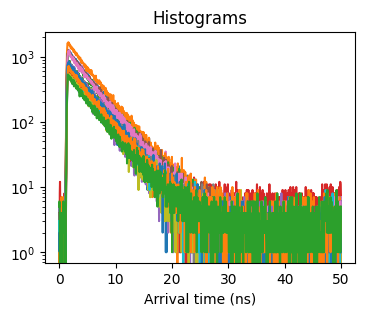

In [3]:
plt.figure(figsize=(4,3))
for det in range(23):
    hist = getattr(data, "hist" + str(det+9))
    plt.plot(1e-3*hist[:,0], hist[:,1])
plt.xlabel('Arrival time (ns)')
plt.title('Histograms')
plt.yscale('log')

Calculate correlations

In [4]:
accuracy = 20 # the higher this number, the more points the correlation will have
split = 1 # split the data in segments of this length (in seconds) and calculate the ACF for each segment separately
return_time_trace = True # return the intensity time trace
list_of_g, list_of_g_out, averaging = get_corr_input(corrtype='spot-variation fcs', det='pda-23')

In [5]:
G, time_trace = correlate_file(file, list_of_g=list_of_g, accuracy=accuracy, split=split, time_trace=return_time_trace, list_of_g_out=list_of_g_out, averaging=averaging)

tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorTCSPCChan', index=4, typecode=268435464, value=9
tag index out of order @ 'DNA_40bp_Alexa488.ptu' tagid='DetectorNumTCSPCChan', index=4, typecode=268435464, value=23


Calculating correlation picentral
Extracting photons
Calculating correlation piring1
Extracting photons
Calculating correlation piring2
Extracting photons


### Plot time-trace and finger print

The time-trace is a compressed data set of max. 1000 time points per channel.

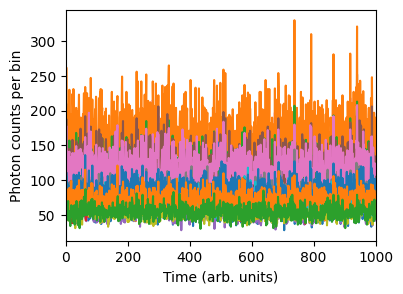

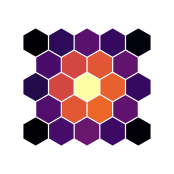

In [8]:
plt.figure(figsize=(4,3))
for i in range(23):
    plt.plot(time_trace[:,i])
plt.xlim([0,1000])
plt.xlabel('Time (arb. units)')
plt.ylabel('Photon counts per bin')

_ = plot_fingerprint_luminosa(np.sum(time_trace, 0), cmap='inferno', plot=True, figsize=(2,2))

### Plot correlations

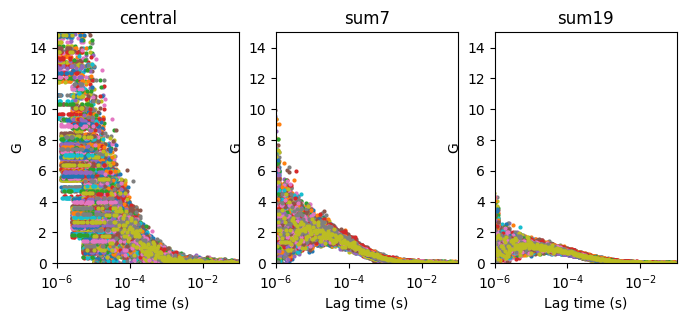

In [9]:
num_chunks = G.num_chunks

f, axs = plt.subplots(1, len(list_of_g_out), figsize=(8,3))

for i, corr in enumerate(list_of_g_out):
    for j in range(num_chunks):
        Gsingle = getattr(G, corr + '_chunk' + str(j))
        axs[i].scatter(Gsingle[1:,0], Gsingle[1:,1], s=4, label='chunk ' + str(j))
    axs[i].set_xscale('log')
    axs[i].set_title(corr)
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_ylabel('G')
    axs[i].set_xlim([1e-6, 1e-1])
    axs[i].set_ylim([0, 15])

### Average over good chunks

In [10]:
idx = good_chunks_idx(G, filt='sum19', f_acc=0.66) # look at the sum5 and accept 66 percent
G.average_chunks(idx) # average good chunks

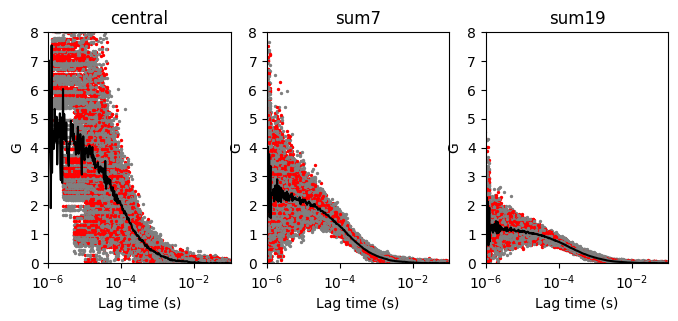

In [9]:
f, axs = plt.subplots(1, len(list_of_g), figsize=(8,3))

for i, corr in enumerate(list_of_g_out):
    for j in range(num_chunks):
        Gsingle = getattr(G, corr + '_chunk' + str(j))
        c='r'
        if j in idx:
            c='gray'
        axs[i].scatter(Gsingle[1:,0], Gsingle[1:,1], s=2, label='chunk ' + str(j), c=c)
    axs[i].set_xscale('log')
    axs[i].set_title(corr)
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_ylabel('G')
    axs[i].set_xlim([1e-6, 1e-1])
    axs[i].set_ylim([0, 8])
    axs[i].plot(Gsingle[1:,0], getattr(G, corr + '_averageX')[1:,1], 'k')

## Fit correlations

### Fit 1 component 3D diffusion Gaussian volume

For fitfun = 'fitfun_2c', the order of the parameters for fitting is
* N: number of particles in focal volume [dim.less]
* tauD1: diffusion time species 1 [ms]
* tauD2: diffusion time species 2 [ms]
* F: fraction of species 1 [dim.less]
* alpha: relative molecular brightness [dim.less]
* T: fraction in triplet [dim.less]
* tautrip: residence time in triplet state [µs]
* SF: shape factor [dim.less]
* offset  [dim.less]
* A, B    afterpulsing properties

In [16]:
start_idx = 122 # start index of the fit
stop_idx = -1 # stop index

fitfun = 'fitfun_2c'
fit_info = np.asarray([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # fit N, tauD, and offset (we fit with one component)
param = np.asarray([1.0, 1, 1, 1, 0, 0, 1, 5, 0, 0, 0]) # starting values for all parameters
lBounds = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0 # lower bounds for all parameters
uBounds = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*(1e6) # upper bounds for all parameters

fitresults = []
for corr in list_of_g_out:
    Gsingle = getattr(G, corr + '_averageX')
    Gexp = Gsingle[start_idx:stop_idx,1]
    tau = Gsingle[start_idx:stop_idx,0]
    fitresult = fcs_fit(Gexp, tau, fitfun, fit_info, param, lBounds, uBounds, plotInfo=-1)
    fitresults.append(fitresult)

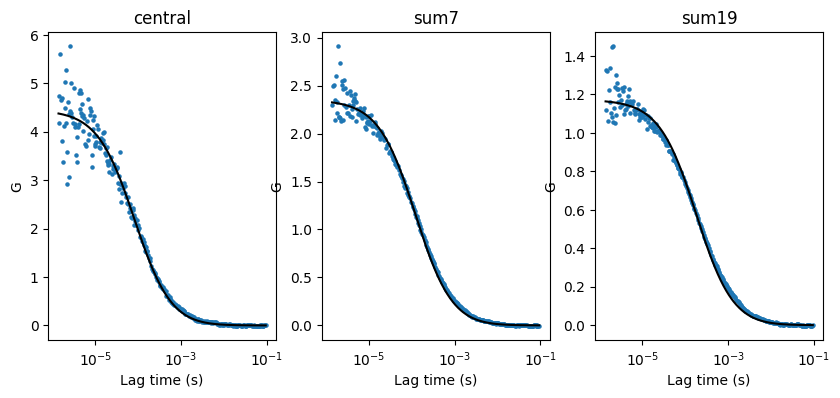

In [17]:
f, axs = plt.subplots(1, len(list_of_g), figsize=(10,4))

for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    fitresult = fitresults[i]
    
    axs[i].scatter(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1], s=5, label=corr)
    axs[i].plot(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1]-fitresult.fun, c='k')
    axs[i].set_xscale('log')
    axs[i].set_title(corr)
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_ylabel('G')

In [18]:
for i, corr in enumerate(list_of_g):
    fitresult = fitresults[i]
    print(corr)
    print(f"N = {fitresult.x[0]:.2f}")
    print(f"tau_D = {fitresult.x[1]:.2f} ms\n")
# fitresult.fun

picentral
N = 0.22
tau_D = 0.08 ms

piring1
N = 0.43
tau_D = 0.12 ms

piring2
N = 0.85
tau_D = 0.18 ms



### Fit diffusion law

Text(0, 0.5, 'Diffusion time (ms)')

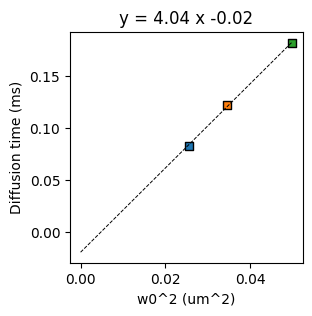

In [19]:
taufit = [fitresult.x[1] for fitresult in fitresults]
w0 = 1e-3*np.asarray([159.8, 185.7, 223.4])
fitresult = fit_curve(taufit, (w0)**2, 'linear', [1, 1], [1, 1], [-1e6, -1e6], [1e6, 1e6], savefig=0)

plt.figure(figsize=(3,3))
for i in range(len(taufit)):
    plt.scatter(w0[i]**2, taufit[i], edgecolors='k', marker='s')
w02fit = np.zeros(len(w0) + 1)
w02fit[0] = 0
w02fit[1:] = w0**2
taufitres = np.zeros(len(w0) + 1)
taufitres[0] = fitresult.x[1]
taufitres[1:] = taufit - fitresult.fun
if fitresult.x[1] < 0:
    fitlabel = 'y = {A:.2f} x {B:.2f}'.format(A=fitresult.x[0], B=fitresult.x[1])
else:
    fitlabel = 'y = {A:.2f} x + {B:.2f}'.format(A=fitresult.x[0], B=fitresult.x[1])
plt.plot(w02fit, taufitres, '--', color='k', linewidth=0.7, label=fitlabel, zorder=1)
plt.title(fitlabel)
plt.xlabel('w0^2 (um^2)')
plt.ylabel('Diffusion time (ms)')

## Calculate filter functions to remove dark counts, afterpulsing, etc.

### Select only reasonable portion of histograms for filtering

In [21]:
filter_range(data) # find start and stop value of the usable decay and store in data.fit_range

Text(0.5, 1.0, 'Grey microtimes excluded from further analysis')

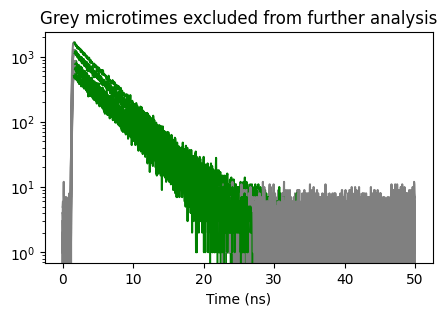

In [22]:
plt.figure(figsize=(5,3))

fitrange = data.fit_range
all_ch = atimes_data_2_channels(data)

for i, det in enumerate(all_ch):
    fitr = fitrange[i]
    hist = getattr(data, "hist" + str(det[3:]))
    plt.plot(1e-3*hist[0:fitr[0],0], hist[0:fitr[0],1], 'grey')
    plt.plot(1e-3*hist[fitr[0]:fitr[1],0], hist[fitr[0]:fitr[1],1], 'g')
    plt.plot(1e-3*hist[fitr[1]:,0], hist[fitr[1]:,1], 'grey')
plt.xlabel('Time (ns)')
plt.yscale('log')
plt.title('Grey microtimes excluded from further analysis')

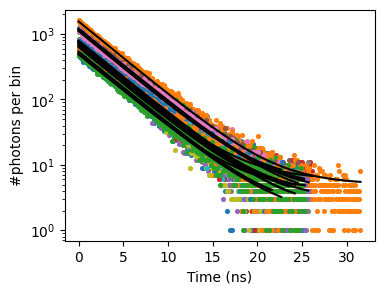

In [23]:
fitresults = np.zeros((len(all_ch), 4))

plt.figure(figsize=(4,3))
for i, det in enumerate(all_ch):
    # get histogram detector element i
    [idxStart, idxStop] = data.fit_range[i, :]
    fitRangeL = idxStop - idxStart
    
    Ihist_single = getattr(data, "hist" + str(det[3:])) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = Ihist_single[idxStart:idxStop, 1]
    lifetime_bins = Ihist_single[0:fitRangeL, 0]

    plt.scatter(1e-3*lifetime_bins, Ihist, s=7)
    plt.xlabel("Time (ns)")
    plt.ylabel("#photons per bin")

    # fit exponential
    fitresult = fit_curve(Ihist, lifetime_bins, 'exp', np.asarray([1, 1, 1, 1]), np.asarray([60000, 0.5, 10, 0]), np.asarray([0, 0, -1e4,-1e4]), np.asarray([1e6, 20, 1e6,1e6]))
    A      = fitresult.x[0]
    alpha  = fitresult.x[1]
    B     = fitresult.x[2]
    dx      = fitresult.x[3]
    plt.plot(1e-3*lifetime_bins, A * np.exp(-alpha * (lifetime_bins-dx)) + B, color='k')
    plt.yscale('log')

    fitresults[i, :] = [A, alpha, B, dx]

In [24]:
mean_val = 1e-3 * np.mean(1 / fitresults[:, 1])
std_val  = 1e-3 * np.std(1 / fitresults[:, 1])

print(f"average lifetime: {mean_val:.2f} ± {std_val:.2f} ns")

average lifetime: 3.89 ± 0.03 ns


### Calculate filter functions

In [25]:
n_ch = len(all_ch)
filters_theo = np.zeros((n_ch, len(hist), 2))
for det in range(n_ch):
    # calculate filter 
    tau = 1 / fitresults[det, 1] / lifetime_bins[1] # tau in dim.less units of bin time
    A = fitresults[det, 0]
    B = fitresults[det, 2]
    T = int(np.diff(data.fit_range[det, :])[0])
    offset = B / A # relative offset, wrt amplitude
    
    # calculate filter
    Ftheo = filter_ap(0, tau, T, offset, norm_exp=False, plot_fig=False)
    # microtimes outside filter set to 0
    [startIdx, stopIdx] = data.fit_range[det, :]
    filters_theo[det, startIdx:stopIdx, :] = np.transpose(Ftheo)

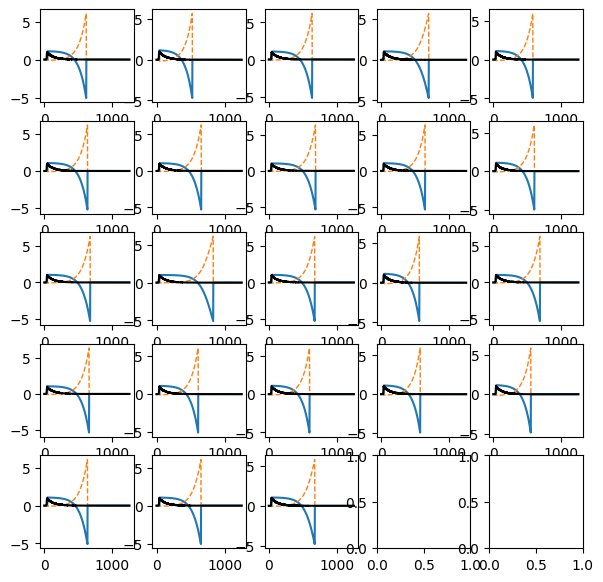

In [26]:
f, axs = plt.subplots(5, 5, figsize=(7,7))

for idx_det, det in enumerate(all_ch):
    Ihist_single = getattr(data, "hist" + str(det[3:]))
    j = np.mod(idx_det, 5)
    i = idx_det // 5
    axs[i, j].plot(filters_theo[idx_det, :, 0])
    axs[i, j].plot(filters_theo[idx_det, :, 1], linestyle='--', linewidth=1.0)
    axs[i, j].plot(Ihist_single[:,1]/np.max(Ihist_single[:,1]), color='black')

### Apply filter weights to all photons based on microtimes

In [27]:
data.microbintime = 1e-12*lifetime_bins[1] # s
data.microtime = 1e-12
data.macrotime = 1e-12
atimes_filtered(data, filters_theo, micro_bin=False, verbose=False)

In [28]:
G = correlate_data(data, list_of_g=list_of_g, accuracy=accuracy, split=split, list_of_g_out=list_of_g_out, averaging=averaging)
G.average_chunks(idx) # average good chunks

Calculating correlation picentral
Extracting photons
   Filter 1
   Filter 2
Calculating correlation piring1
Extracting photons
   Filter 1
   Filter 2
Calculating correlation piring2
Extracting photons
   Filter 1
   Filter 2


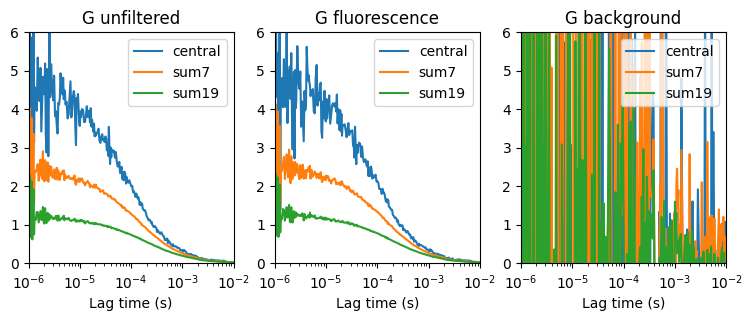

<Figure size 640x480 with 0 Axes>

In [24]:
titles = ['G unfiltered', 'G fluorescence', 'G background']
f, axs = plt.subplots(1, 3, figsize=(9,3))
plt.figure()
for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    axs[0].plot(Gsingle[:,0], Gsingle[:,1], label=corr)
    Gsingle = getattr(G, corr + 'F1_averageX')
    axs[1].plot(Gsingle[:,0], Gsingle[:,1], label=corr)
    Gsingle = getattr(G, corr + 'F2_averageX')
    axs[2].plot(Gsingle[:,0], Gsingle[:,1], label=corr)
    
    axs[i].set_xscale('log')
    axs[i].set_xlim([1e-6, 1e-2])
    axs[i].set_ylim([0, 6])
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_title(titles[i])

for i in range(3):
    axs[i].legend()

In [25]:
start_idx = 350 # start index of the fit
stop_idx = -1 # stop index

fitfun = 'fitfun_2c'
fit_info = np.asarray([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # fit N, tauD, and offset (we fit with one component)
param = np.asarray([1.0, 1, 1, 1, 0, 0, 1, 5, 0, 0, 0]) # starting values for all parameters
lBounds = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0 # lower bounds for all parameters
uBounds = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])*(1e6) # upper bounds for all parameters

fitresults = []
for corr in list_of_g_out:
    Gsingle = getattr(G, corr + 'F1_averageX')
    Gexp = Gsingle[start_idx:stop_idx,1]
    tau = Gsingle[start_idx:stop_idx,0]
    fitresult = fcs_fit(Gexp, tau, fitfun, fit_info, param, lBounds, uBounds, plotInfo=-1)
    fitresults.append(fitresult)

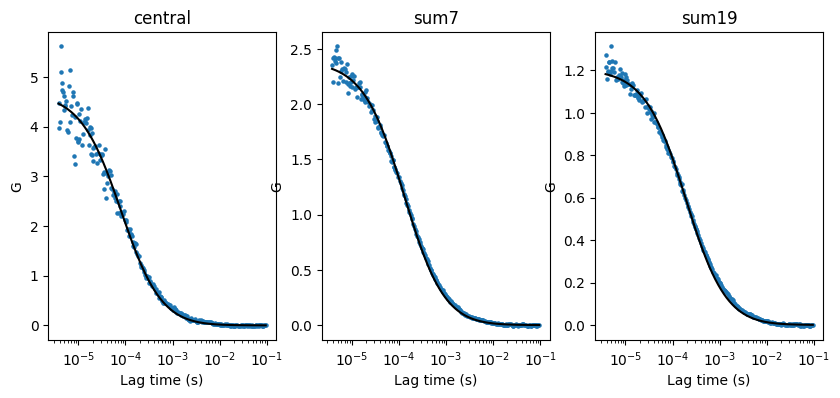

In [26]:
f, axs = plt.subplots(1, len(list_of_g), figsize=(10,4))

for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + 'F1_averageX')
    fitresult = fitresults[i]
    
    axs[i].scatter(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1], s=5, label=corr)
    axs[i].plot(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1]-fitresult.fun, c='k')
    axs[i].set_xscale('log')
    axs[i].set_title(corr)
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_ylabel('G')

In [28]:
for i, corr in enumerate(list_of_g_out):
    fitresult = fitresults[i]
    print(corr)
    print(f"N = {fitresult.x[0]:.2f}")
    print(f"tau_D = {fitresult.x[1]:.2f} ms\n")

central
N = 0.21
tau_D = 0.08 ms

sum7
N = 0.42
tau_D = 0.13 ms

sum19
N = 0.83
tau_D = 0.19 ms



Text(0, 0.5, 'Diffusion time (ms)')

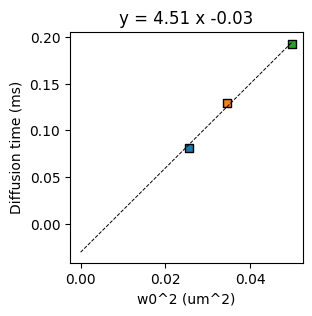

In [29]:
taufit = [fitresult.x[1] for fitresult in fitresults]
w0 = 1e-3*np.asarray([159.8, 185.7, 223.4])
fitresult = fit_curve(taufit, (w0)**2, 'linear', [1, 1], [1, 1], [-1e6, -1e6], [1e6, 1e6], savefig=0)

plt.figure(figsize=(3,3))
for i in range(len(taufit)):
    plt.scatter(w0[i]**2, taufit[i], edgecolors='k', marker='s')
w02fit = np.zeros(len(w0) + 1)
w02fit[0] = 0
w02fit[1:] = w0**2
taufitres = np.zeros(len(w0) + 1)
taufitres[0] = fitresult.x[1]
taufitres[1:] = taufit - fitresult.fun
if fitresult.x[1] < 0:
    fitlabel = 'y = {A:.2f} x {B:.2f}'.format(A=fitresult.x[0], B=fitresult.x[1])
else:
    fitlabel = 'y = {A:.2f} x + {B:.2f}'.format(A=fitresult.x[0], B=fitresult.x[1])
plt.plot(w02fit, taufitres, '--', color='k', linewidth=0.7, label=fitlabel, zorder=1)
plt.title(fitlabel)
plt.xlabel('w0^2 (um^2)')
plt.ylabel('Diffusion time (ms)')